# Data Manipulation

In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv("train_loanPredict_AV.csv", index_col="Loan_ID")

In [2]:
# Boolean Indexing
#.loc returns df
f = data.loc[(data["Gender"] == "Female") & (data["Education"] == "Not Graduate") & (data["Loan_Status"] == "Y"), ["Gender", "Education", "Loan_Status"]]
print (f)
print ("\nTotal Count: ", f["Gender"].count())

          Gender     Education Loan_Status
Loan_ID                                   
LP001155  Female  Not Graduate           Y
LP001669  Female  Not Graduate           Y
LP001692  Female  Not Graduate           Y
LP001908  Female  Not Graduate           Y
LP002300  Female  Not Graduate           Y
LP002314  Female  Not Graduate           Y
LP002407  Female  Not Graduate           Y
LP002489  Female  Not Graduate           Y
LP002502  Female  Not Graduate           Y
LP002534  Female  Not Graduate           Y
LP002582  Female  Not Graduate           Y
LP002731  Female  Not Graduate           Y
LP002757  Female  Not Graduate           Y
LP002917  Female  Not Graduate           Y

Total Count:  14


In [3]:
# Apply returns some value after passing each row/column of a data frame with some function
def find_missing(x):
    return sum(x.isnull())

print ("Missing values per column")
print (data.apply(find_missing, axis = 0)) # axis=0 - is applied to each column
print ("\nMissing values per row")
print (data.apply(find_missing, axis = 1).head()) # axis=1 - is applied to each row

Missing values per column
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

Missing values per row
Loan_ID
LP001002    1
LP001003    0
LP001005    0
LP001006    0
LP001008    0
dtype: int64


In [4]:
# Imputing missing values
from scipy.stats import mode

# mode can be an array as there can be multiple values with high frequency. 
# We will take the first one by default always - using mode()[0]

data['Gender'].fillna(data['Gender'].mode()[0], inplace = True)
data['Married'].fillna(data['Married'].mode()[0], inplace=True)
data['Self_Employed'].fillna(data['Self_Employed'].mode()[0], inplace=True)

# Now check the missing values again to confirm
print (data.apply(find_missing, axis=0))  # axis=0 - is applied to each column


Gender                0
Married               0
Dependents           15
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


To create MS Excel style pivot tables,  in this case, a key column is “LoanAmount” which has missing values. 
We can impute it using mean amount of each ‘Gender’, ‘Married’ and ‘Self_Employed’ group.
Also Each index is made up of a combination of 3 values. 
This is called Multi-Indexing. It helps in performing operations really fast.


In [5]:
impute_Loan = data.pivot_table(values = ["LoanAmount"], index = ["Gender", "Married", "Self_Employed"], aggfunc = np.mean)
print(impute_Loan)


                              LoanAmount
Gender Married Self_Employed            
Female No      No             114.691176
               Yes            125.800000
       Yes     No             134.222222
               Yes            282.250000
Male   No      No             129.936937
               Yes            180.588235
       Yes     No             153.882736
               Yes            169.395833


Imputing the calculated values:

Multi-index requires tuple for defining groups of indices in loc statement

.values[0] suffix is required because, by default a series element is returned which has an index not matching with that of the dataframe. In this case, a direct assignment gives an error.


In [6]:
for i,row in data.loc[data["LoanAmount"].isnull(),:].iterrows():
    index = tuple([row["Gender"], row["Married"], row["Self_Employed"]])
    data.loc[i, "LoanAmount"] = impute_Loan.loc[index].values[0] 

    # values is used to get the scalar numeric value, rather than along with the column name

#print (index)
#print (impute_Loan.loc[index].values[0]) 
# check missing values of LoanAmount
print (data.apply(find_missing, axis=0))

Gender                0
Married               0
Dependents           15
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


'crosstab' This function is used to get an initial “feel” (view) of the data. Here, we can validate some basic hypothesis. 
For instance, in this case, “Credit_History” is expected to affect the loan status significantly. 
This can be tested using cross-tabulation as shown below:

In [7]:
pd.crosstab(data["Credit_History"], data['Loan_Status'], margins = True)

# to view this in %, apply below fn.

def findpercentage(x):
    return x/float(x[-1])

pd.crosstab(data["Credit_History"], data['Loan_Status'], margins = True).apply(findpercentage, axis = 1)


Loan_Status,N,Y,All
Credit_History,,,
0.0,0.921348,0.078652,1.0
1.0,0.204211,0.795789,1.0
All,0.317376,0.682624,1.0


Now, it is evident that people with a credit history have much higher chances of getting a loan as 80% people with credit 
history got a loan as compared to only 9% without credit history.

But that’s not it. It tells an interesting story. Since I know that having a credit history is super important, 
what if I predict loan status to be Y for ones with credit history and N otherwise. Surprisingly, 
we’ll be right 82+378=460 times out of 614 which is a whopping 75%!

I won’t blame you if you’re wondering why the hell do we need statistical models. 
But trust me, increasing the accuracy by even 0.001% beyond this mark is a challenging task. 

Note: 75% accuracy is on train set. The test set will be slightly different but close. 
Also, I hope this gives some intuition into why even a 0.05% increase in accuracy can result in jump of 500 ranks 
on the Kaggle leaderboard.


In [8]:
# Merge dataframes

prop_rates = pd.DataFrame([1000,3000,6000], index = ['Rural','Semiurban','Urban'], columns = ['rates'])
prop_rates

,rates
Rural,1000
Semiurban,3000
Urban,6000


In [9]:
# Merging df
# right df is prop_rates, inner is intersection of both the keys, left on - col frm left df to be used as key, 
# right index -if True,use right row/index as keys to merge. refer: https://pandas.pydata.org/pandas-docs/stable/merging.html

merged_data = data.merge(right=prop_rates, how='inner', left_on='Property_Area', right_index=True, sort=False) 
# to confirm merge
merged_data.pivot_table(values='LoanAmount', index = ['Property_Area', 'rates'], aggfunc = len) # values can have any col name, 
                                                                                            # we are jus counting total values


,,LoanAmount
Property_Area,rates,
Rural,1000,179.0
Semiurban,3000,233.0
Urban,6000,202.0


In [10]:
# Sorting df
data_sorted = data.sort_values(['ApplicantIncome','CoapplicantIncome'], ascending = False)
data_sorted[['ApplicantIncome','CoapplicantIncome']].head(10)

,ApplicantIncome,CoapplicantIncome
Loan_ID,,
LP002317,81000,0.0
LP002101,63337,0.0
LP001585,51763,0.0
LP001536,39999,0.0
LP001640,39147,4750.0
LP002422,37719,0.0
LP001637,33846,0.0
LP001448,23803,0.0
LP002624,20833,6667.0


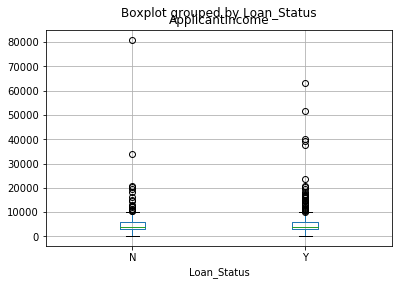

In [11]:
# plotting df - boxplot and hist in pandas
%matplotlib inline

import matplotlib.pyplot as plt

data.boxplot(column='ApplicantIncome', by='Loan_Status')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001D6BCDEDB38>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000001D6BCEF56D8>], dtype=object)

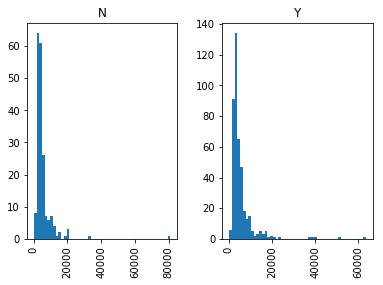

In [12]:
data.hist(column='ApplicantIncome', by='Loan_Status', bins = 50)# bins-no. of pillars/groups the data is divided into in the plot

In [13]:
# to bin data into different bins using cut function

def binning(col, breaks, labels):
    min_value = col.min()
    max_value = col.max()
    
    break_pts = [min_value] + breaks + [max_value]
    
    #if no labels provided, use default labels 0 ... (n-1)
    if not labels:
        labels = range(len(breaks)+1)

    bins = pd.cut(col, bins=break_pts, labels=labels, include_lowest=True)
    return bins

# Binning based on loan amount   

break_pts=[90,140,190]
labels=["low","medium","high","very high"]
data["LoanAmount_bin"] = binning(data["LoanAmount"], break_pts, labels)
print (pd.value_counts(data["LoanAmount_bin"], sort=False))

    

low          104
medium       273
high         146
very high     91
Name: LoanAmount_bin, dtype: int64


Often, we find a case where we’ve to modify the categories of a nominal variable. This can be due to various reasons:

Some algorithms (like Logistic Regression) require all inputs to be numeric. So nominal variables are mostly coded as 0, 1….(n-1)
Sometimes a category might be represented in 2 ways. For e.g. temperature might be recorded as “High”, “Medium”, “Low”, “H”, 
“low”. Here, both “High” and “H” refer to same category. Similarly, in “Low” and “low” there is only a difference of case. 
But, python would read them as different levels.
Some categories might have very low frequencies and its generally a good idea to combine them.
Here I’ve defined a generic function which takes in input as a dictionary and codes the values using ‘replace’ function in Pandas.

In [15]:
def coding(col, codeDict):
    colCoded = pd.Series(col, copy=True)
    for key, value in codeDict.items():
        colCoded.replace(key, value, inplace=True)
    return colCoded

print ("Before coding: ")
print (pd.value_counts(data["Loan_Status"]))
data["Loan_Status_Coded"] = coding(data["Loan_Status"], {'N':0,'Y':1})
print ("After coding: ")
print (pd.value_counts(data["Loan_Status_Coded"]))


Before coding: 
Y    422
N    192
Name: Loan_Status, dtype: int64
After coding: 
1    422
0    192
Name: Loan_Status_Coded, dtype: int64


 Iterating over rows of a dataframe

This is not a frequently used operation. Still, you don’t want to get stuck. At times you may need to iterate through all rows using a for loop. For instance, one common problem we face is the incorrect treatment of variables in Python. This generally happens when:

1. Nominal variables with numeric categories are treated as numerical.
2. Numeric variables with characters entered in one of the rows (due to a data error) are considered categorical.
3. So it’s generally a good idea to manually define the column types. If we check the data types of all columns:


In [17]:
# check current datatypes by row
data.dtypes

Gender                 object
Married                object
Dependents             object
Education              object
Self_Employed          object
ApplicantIncome         int64
CoapplicantIncome     float64
LoanAmount            float64
Loan_Amount_Term      float64
Credit_History        float64
Property_Area          object
Loan_Status            object
LoanAmount_bin       category
Loan_Status_Coded       int64
dtype: object

Here we see that Credit_History is a nominal variable but appearing as float. A good way to tackle such issues is to 
create a csv file with column names and types. This way, we can make a generic function to read the file and assign 
column data types. For instance, here I have created a csv file datatypes.csv.


In [19]:
colTypes = pd.read_csv('datatypes.csv')
print (colTypes)

              feature         type
0             Loan_ID  categorical
1              Gender  categorical
2             Married  categorical
3          Dependents  categorical
4           Education  categorical
5       Self_Employed  categorical
6     ApplicantIncome   continuous
7   CoapplicantIncome   continuous
8          LoanAmount   continuous
9    Loan_Amount_Term   continuous
10     Credit_History  categorical
11      Property_Area  categorical
12        Loan_Status  categorical


In [20]:
# After loading this file, we can iterate through each row and assign the datatype using column ‘type’ to the variable 
# name defined in the ‘feature’ column.

for i,row in colTypes.iterrows(): #i: dataframe index; row: each row in series format
    if row['feature'] != 'Loan_ID': # data does not include it, so skip it
        if row['type'] == 'categorical':
            data[row['feature']]=data[row['feature']].astype(np.object)
        elif row['type'] == 'continuous':
            data[row['feature']] = data[row['feature']].astype(np.float)
            
# Now the credit history column is modified to ‘object’ type which is used for representing nominal variables in Pandas.
print (data.dtypes)

Gender                 object
Married                object
Dependents             object
Education              object
Self_Employed          object
ApplicantIncome       float64
CoapplicantIncome     float64
LoanAmount            float64
Loan_Amount_Term      float64
Credit_History         object
Property_Area          object
Loan_Status            object
LoanAmount_bin       category
Loan_Status_Coded       int64
dtype: object
